In [1]:
! pip install pandas-ta

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=67177904ebc923cfe838a0b8ada5070396d69a5617650cf40da6252ce03f729b
  Stored in directory: /home/ubuntu/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
! pip install boto3
! pip install scikit-learn
! pip install keras
! pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01

In [9]:
import math
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import datetime as dt
import boto3
import csv
import datetime

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

2023-10-23 16:05:02.064583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 16:05:02.105518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 16:05:02.105546: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 16:05:02.105580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 16:05:02.113483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 16:05:02.113797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [5]:
import boto3
import botocore

BUCKET_NAME = 'yariksbucket' # replace with your bucket name
KEY = 'crypto/archive/BTC-2017min.csv' # replace with your object key

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'BTC-2017min.csv')
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'BTC-2018min.csv')
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'BTC-2019min.csv')
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'BTC-2020min.csv')
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'BTC-2021min.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [35]:
import pandas as pd
import glob

# Get a list of CSV files in the directory in the specific order
file_list = ['BTC-2017min.csv', 'BTC-2018min.csv', 'BTC-2019min.csv', 'BTC-2020min.csv', 'BTC-2021min.csv']  # Replace with your specific order

# Create an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Loop through the list of CSV files and concatenate them
for file in file_list[::-1]:
    df = pd.read_csv(file)
    merged_df = pd.concat([merged_df, df], ignore_index=True)

merged_df = merged_df[::-1]

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('BTC-2017-2021.csv', index=False)

In [36]:
import csv
file = open('BTC-2017-2021.csv')
csvreader = csv.reader(file)
header = []
header = next(csvreader)

In [37]:
data = pd.read_csv("BTC-2017-2021.csv", names=header, skiprows=1)
data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1483228860,2017-01-01 00:01:00,BTC/USD,966.34,966.34,966.34,966.34,7.610000,7353.847400
1,1483228920,2017-01-01 00:02:00,BTC/USD,966.16,966.37,966.16,966.37,8.087376,7815.397864
2,1483228980,2017-01-01 00:03:00,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
3,1483229040,2017-01-01 00:04:00,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
4,1483229100,2017-01-01 00:05:00,BTC/USD,966.43,966.43,966.43,966.43,0.107000,103.408010


In [38]:
import datetime
open_date = []
for timestamp in data["unix"]:
    # print(timestamp)
    open_date.append(datetime.datetime.fromtimestamp(timestamp))

data["unix"] = open_date
data = data.drop('unix', axis=1)
data

,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,2017-01-01 00:01:00,BTC/USD,966.34,966.34,966.34,966.34,7.610000,7353.847400
1,2017-01-01 00:02:00,BTC/USD,966.16,966.37,966.16,966.37,8.087376,7815.397864
2,2017-01-01 00:03:00,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
3,2017-01-01 00:04:00,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
4,2017-01-01 00:05:00,BTC/USD,966.43,966.43,966.43,966.43,0.107000,103.408010
...,...,...,...,...,...,...,...,...
2675296,2022-03-01 03:38:00,BTC/USD,43077.82,43077.82,43049.46,43049.46,0.022210,956.143143
2675297,2022-03-01 03:39:00,BTC/USD,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
2675298,2022-03-01 03:40:00,BTC/USD,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
2675299,2022-03-01 03:41:00,BTC/USD,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021


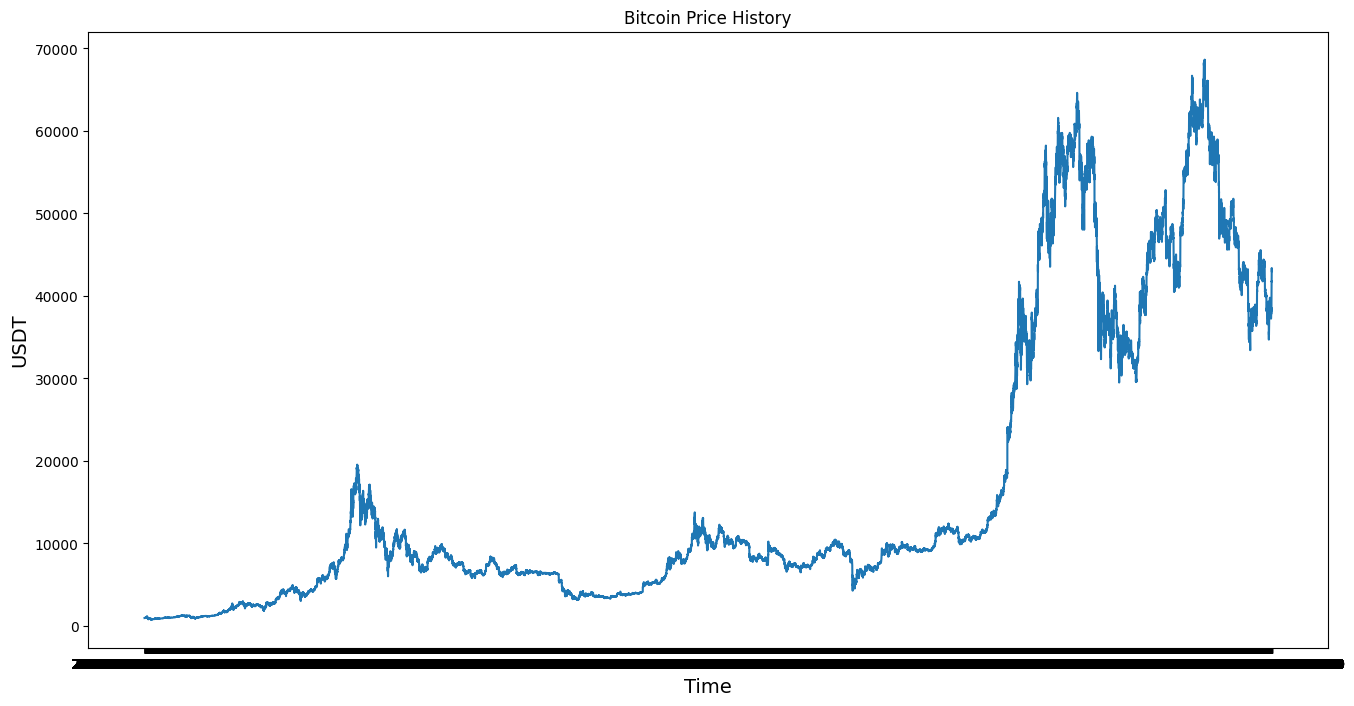

In [39]:
import matplotlib.pyplot as plt
# Visualize the close price history
data_shrinked = data.iloc[::60, :] # We shrink data by 60 to improve performance
plt.figure(figsize=(16, 8))
plt.title("Bitcoin Price History")
plt.plot(data_shrinked["date"], data_shrinked["close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

In [40]:
import math
# Create new data with only the "Close" column
close = data.filter(["close"])
# Convert the dataframe to a np array
close_array = close.values
# See the train data len
train_close_len = math.ceil(len(close_array) * 0.8)
train_close_len

2140241

In [41]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_array)
scaled_data

array([[0.00314002],
       [0.00314046],
       [0.00314046],
       ...,
       [0.61927111],
       [0.61971874],
       [0.61971874]])

In [42]:
# Create the training dataset
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(X_train)
        print(y_train)

[array([0.00314002, 0.00314046, 0.00314046, 0.00314046, 0.00314134,
       0.00314354, 0.00314354, 0.00314354, 0.00314354, 0.00314339,
       0.00314149, 0.00312888, 0.00312888, 0.00312845, 0.00314339,
       0.00312859, 0.00312859, 0.00312845, 0.00312845, 0.00312845,
       0.00312845, 0.00314295, 0.00314295, 0.00311848, 0.00311848,
       0.00311848, 0.00311848, 0.00311848, 0.0031239 , 0.0031239 ,
       0.0031239 , 0.0031239 , 0.0031239 , 0.0031239 , 0.00314046,
       0.00314046, 0.0031409 , 0.00314075, 0.00314075, 0.0031409 ,
       0.0031409 , 0.00314075, 0.00314075, 0.00314061, 0.00313416,
       0.00313504, 0.0031409 , 0.00314925, 0.00314925, 0.00314925,
       0.00314925, 0.00314925, 0.00314925, 0.00314925, 0.00314925,
       0.00314954, 0.00314954, 0.00314383, 0.00314383, 0.00314383])]
[0.0031438302331674092]


In [43]:
import numpy as np
#  make X_train and y_train np array
X_train, y_train = np.array(X_train), np.array(y_train)

In [44]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2140181, 60, 1)

In [45]:
# create the testing dataset
test_data = scaled_data[train_close_len - 60 : , :]
# create X_test and y_test
X_test = []
y_test = data.iloc[train_close_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

In [46]:
# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [50]:
from keras import Sequential
from keras.layers import LSTM, Dense
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))


model.add(LSTM(units=256, activation='relu', return_sequences=False))


model.add(Dense(units=1))

In [51]:
# compile the LSTM model
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [52]:
# train the LSTM model
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

2023-10-23 16:45:45.950612: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 513643440 exceeds 10% of free system memory.


Epoch 1/3
 6795/21402 [========>.....................] - ETA: 58:02 - loss: 1.5794e-05 - mae: 0.0011

: 

: 